<a href="https://colab.research.google.com/github/LAMECH9/LAMECH9/blob/main/CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to CNN Keras - Acc 0.997 (top 8%)

# 1. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a single CPU (i5 2500k). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster !!!

For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.

This Notebook follows three main parts:

The data preparation
The CNN modeling and evaluation
The results prediction and submission

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.

# 2. Data preparation

# 2.1 Load data

In [ ]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

,count
label,
1,4684
7,4401
3,4351
9,4188
2,4177
6,4137
0,4132
4,4072
8,4063


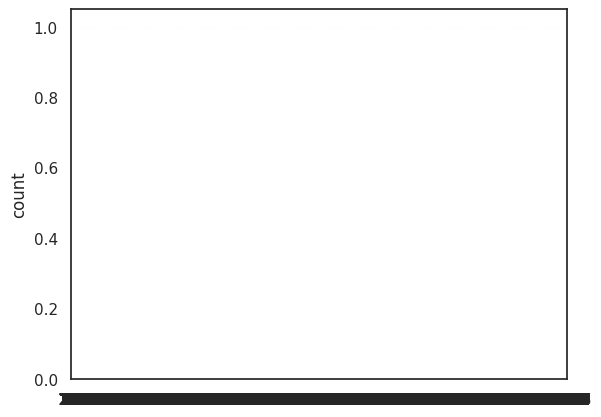

In [ ]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

We have similar counts for the 10 digits.

# 2.2 Check for null and missing values

In [ ]:
# Check the data
X_train.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


In [ ]:
test.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

# 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [ ]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# 2.3 Reshape

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

# 2.5 Label encoding

In [17]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

# 2.6 Split training and valdiation set

In [18]:
# Set the random seed
random_seed = 2

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

We can get a better sense for one of these examples by visualising the image and looking at the label.

In [7]:
import matplotlib.pyplot as plt
# Set the random seed
random_seed = 2

# Some examples
g = plt.imshow(X_train[0][:,:,0])

NameError: name 'X_train' is not defined

In [6]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

NameError: name 'X_train' is not defined